In [1]:
import geopandas as gpd
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np
import rasterio
from matplotlib.colors import ListedColormap
from rasterio.mask import mask
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'geopandas'

In [3]:
counties_data = gpd.read_file("counties.geojson")

In [4]:
len(counties_data)

72

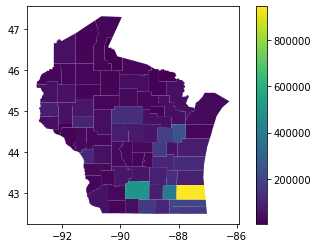

In [5]:
counties_data.plot(column=counties_data['POP100'], cmap='viridis',legend='True')
None

In [6]:
conn = sqlite3.connect('counties_tracts.db')

In [7]:
counties = pd.read_sql("""SELECT * FROM counties""", conn)
arealand = counties['AREALAND']
counties_data = counties_data.assign(AREALAND=arealand)

In [8]:
train, test = train_test_split(counties_data, test_size=0.25, random_state=320)

In [9]:
test['NAME'].tolist()

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [10]:
model = LinearRegression()
model.fit(train[['AREALAND']], train['POP100'])
model.score(test[['AREALAND']], test['POP100'])

0.022002661530554857

In [11]:
num = 500 * 2.59 * 1000**2
predicted_df = pd.DataFrame({"AREALAND": [num]})
predicted_df['y_value'] = model.predict(predicted_df)
predicted_df['y_value'][0]

82032.53073541154

In [12]:
tracts = pd.read_sql("""SELECT * FROM tracts""", conn)

In [13]:
hu100_data = pd.read_sql("""
  SELECT counties.NAME, SUM(HU100) AS HU1001
  FROM counties INNER JOIN tracts 
  ON counties.COUNTY = tracts.COUNTY
  GROUP BY counties.COUNTY, tracts.COUNTY
  """, conn)

In [14]:
counties_data = counties_data.merge(hu100_data, on = "NAME", how = "left")

In [15]:
train, test = train_test_split(counties_data, test_size=0.25, random_state=320)

In [16]:
test['NAME'].tolist()

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [17]:
train.set_index('NAME').to_dict()['HU1001']

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

In [18]:
model = LinearRegression()
model.fit(train[['HU1001']], train['POP100'])
scores = cross_val_score(model, train[["HU1001"]], train["POP100"])
scores.mean()

0.9652534544116037

In [19]:
scores.std()

0.03704265206670459

In [20]:
f"POP100 = {round(model.coef_[0], 2)}*HU100 + {round(model.intercept_, 2)}"

'POP100 = 2.39*HU100 + -7910.46'

/home/ukmehta/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


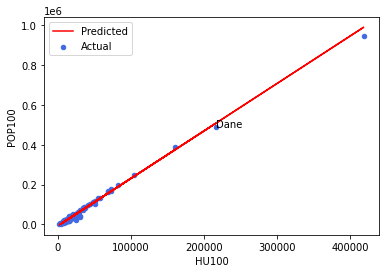

In [21]:
POP100_list = counties_data['POP100'].tolist()
HU100_list = counties_data['HU1001'].tolist()

model.fit(train[['HU1001']].values, train['POP100'].values)
predicted_df = pd.DataFrame({"HU100": HU100_list})
predicted_df["PREDICTED POP100"] = model.predict(predicted_df)

actual_df = pd.DataFrame({'POP100': POP100_list, 'HU100': HU100_list})

ax = predicted_df.plot.line(x="HU100", y="PREDICTED POP100", color="red", label='Predicted')
plt1 = actual_df.plot.scatter(x="HU100", y="POP100", ax=ax, color="royalblue", label='Actual')

index = counties_data.index[counties_data['NAME']=='Dane County'].tolist()[0]
plt1.text(counties_data.loc[index, 'HU1001'], counties_data.loc[index, 'POP100'], "Dane")
None

In [22]:
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
values = (A >= 2) & (A <= 5).astype(int)
values.sum()

12

In [23]:
land = rasterio.open("zip://../p6/land.zip!wi.tif")

In [24]:
milwaukee = counties_data[counties_data['NAME'] == 'Milwaukee County']
matrix, _ = mask(land, milwaukee.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

In [25]:
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

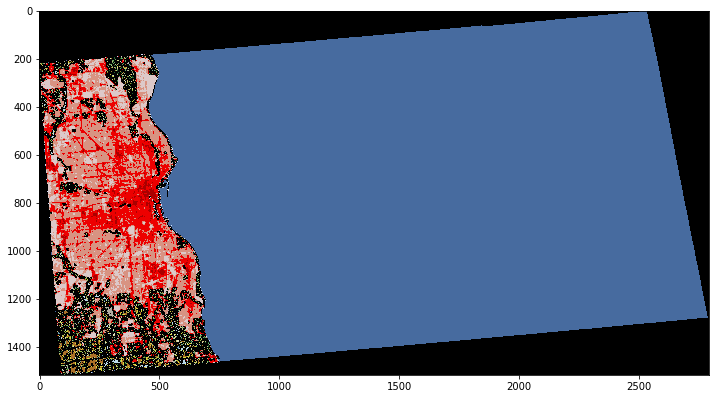

In [26]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)
None

In [27]:
open_water = (matrix == 11).astype(int).sum()
milwaukee_county = (matrix != 0).astype(int).sum()
open_water / milwaukee_county

0.7963037455950543

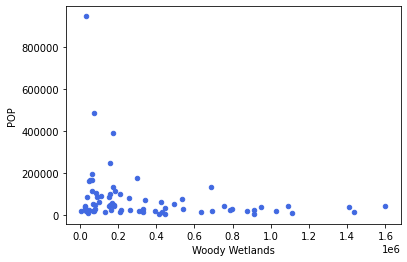

In [28]:
wetland_count_list = []
for row in counties_data[['NAME']].itertuples():
    county = counties_data[counties_data['NAME'] == row[1]]
    woody_matrix, _ = mask(land, county.to_crs(land.crs)["geometry"], crop=True)
    woody_matrix = woody_matrix[0]
    woody_wetlands = (woody_matrix == 90).astype(int).sum()
    wetland_count_list.append(woody_wetlands)

df_to_graph = pd.DataFrame({'POP': POP100_list, 'Woody Wetlands': wetland_count_list})
df_to_graph.plot.scatter(x="Woody Wetlands", y="POP", color="royalblue")
None

In [29]:
tracts_data = gpd.read_file("tracts.geojson")

In [30]:
developed_medium_list = []
developed_high_list = []

for rows in tracts_data.itertuples():
    row = tracts_data.loc[[rows.Index]]
    matrices, _ = mask(land, row.to_crs(land.crs)['geometry'], crop=True)
    matrices = matrices[0]
    medium = np.count_nonzero(matrices == 23)
    developed_medium_list.append(medium)
    high = np.count_nonzero(matrices == 24)
    developed_high_list.append(high)
    
tracts_data['DEVELOPED_MEDIUM'] = developed_medium_list
tracts_data['DEVELOPED_HIGH'] = developed_high_list

In [31]:
train, test = train_test_split(tracts_data, random_state=320)

In [32]:
model1 = LinearRegression()
model2 = LinearRegression()
scores1 = cross_val_score(model1, train[["POP100"]], train["DEVELOPED_MEDIUM"])
scores2 = cross_val_score(model2, train[["POP100"]], train["DEVELOPED_HIGH"])

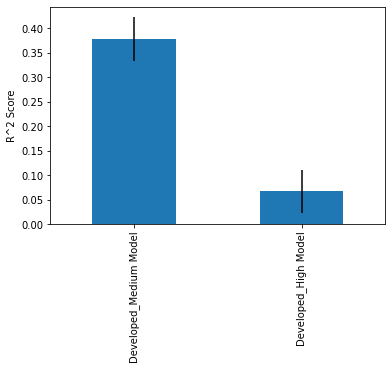

In [33]:
avg = pd.Series({"Developed_Medium Model": scores1.mean(), "Developed_High Model": scores2.mean()})
std = pd.Series({"Developed_Medium Model": scores1.std(), "Developed_High Model": scores2.std()})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")
None

In [34]:
'''I would recommend the Developed_Medium Model -- Model1 -- for this prediction
task because, even though the standard deviation is pretty much the same as other models,
the cross vaidation scores are relatively high. And it's a simple enough model;
there is no extravagant function or equation that is being used.'''

"I would recommend the Developed_Medium Model -- Model1 -- for this prediction\ntask because, even though the standard deviation is pretty much the same as other models,\nthe cross vaidation scores are relatively high. And it's a simple enough model;\nthere is no extravagant function or equation that is being used."

In [35]:
model1.fit(train[['POP100']], train['DEVELOPED_MEDIUM'])
model1.score(test[['POP100']], test['DEVELOPED_MEDIUM'])

0.3526398527257435